<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/main/LSTM_MULTIVARIATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu
Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [2]:
#Read the csv file
df = pd.read_csv('../content/sample_data/GE.csv')
print(df.head()) #7 columns, including the Date. 

         Date        Open        High         Low       Close   Adj Close  \
0  2021-04-19  106.559998  107.760002  105.360001  107.680000  107.324043   
1  2021-04-20  107.279999  107.279999  103.199997  104.480003  104.134628   
2  2021-04-21  103.440002  107.040001  102.160004  106.800003  106.446968   
3  2021-04-22  106.800003  109.440002  106.239998  107.279999  106.925369   
4  2021-04-23  108.000000  108.879997  106.879997  108.400002  108.041672   

    Volume  
0  5609475  
1  7682088  
2  6201013  
3  6575975  
4  5829763  


In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

237   2022-03-25
238   2022-03-28
239   2022-03-29
240   2022-03-30
241   2022-03-31
242   2022-04-01
243   2022-04-04
244   2022-04-05
245   2022-04-06
246   2022-04-07
247   2022-04-08
248   2022-04-11
249   2022-04-12
250   2022-04-13
251   2022-04-14
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [5]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

In [6]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [7]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [8]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [9]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (238, 14, 5).
trainY shape == (238, 1).


In [10]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [11]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 3s 44ms/step - loss: 0.5128 - val_loss: 0.4313
Epoch 2/5
14/14 [==============================] - 0s 16ms/step - loss: 0.3780 - val_loss: 0.1857
Epoch 3/5
14/14 [==============================] - 0s 16ms/step - loss: 0.3067 - val_loss: 0.1080
Epoch 4/5
14/14 [==============================] - 0s 16ms/step - loss: 0.2775 - val_loss: 0.0804
Epoch 5/5
14/14 [==============================] - 0s 16ms/step - loss: 0.2183 - val_loss: 0.0547


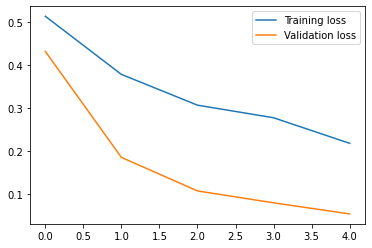

In [12]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [13]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-03-24 00:00:00', freq='C'), Timestamp('2022-03-25 00:00:00', freq='C'), Timestamp('2022-03-28 00:00:00', freq='C'), Timestamp('2022-03-29 00:00:00', freq='C'), Timestamp('2022-03-30 00:00:00', freq='C'), Timestamp('2022-03-31 00:00:00', freq='C'), Timestamp('2022-04-01 00:00:00', freq='C'), Timestamp('2022-04-04 00:00:00', freq='C'), Timestamp('2022-04-05 00:00:00', freq='C'), Timestamp('2022-04-06 00:00:00', freq='C'), Timestamp('2022-04-07 00:00:00', freq='C'), Timestamp('2022-04-08 00:00:00', freq='C'), Timestamp('2022-04-11 00:00:00', freq='C'), Timestamp('2022-04-12 00:00:00', freq='C'), Timestamp('2022-04-13 00:00:00', freq='C')]


In [14]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [15]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [16]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


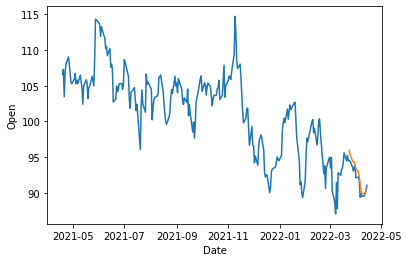

In [17]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])